# Example workflow to model the mass-balance of the Aneto-glacier:

-> you need to install the MBsandbox to be able to run the code (you also need the most recent OGGM version):
  - see: https://github.com/OGGM/massbalance-sandbox#how-to-install


In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import pickle

import matplotlib.pyplot as plt
import matplotlib

from numpy.testing import assert_allclose
import scipy
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import os

import oggm
from oggm import cfg, utils, workflow, tasks, graphics, entity_task
from oggm.utils import date_to_floatyear
from oggm.shop import gcm_climate
from oggm.core import massbalance, flowline, climate

import logging
log = logging.getLogger(__name__)

cfg.initialize() #logging_level='WARNING'
cfg.PARAMS['use_multiprocessing'] = False
cfg.PARAMS['continue_on_error'] = False
cfg.PATHS['working_dir'] = utils.gettempdir(dirname='OGGM-sfc-type', reset=False)

# use Huss flowlines
base_url = ('https://cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/'
            'L1-L2_files/elev_bands')

# import the MBsandbox modules
from MBsandbox.mbmod_daily_oneflowline import (process_w5e5_data, BASENAMES, MultipleFlowlineMassBalance_TIModel, TIModel_Sfc_Type)
from MBsandbox.help_func import minimize_bias_geodetic, minimize_winter_mb_brentq_geod_via_pf

cfg.PARAMS['hydro_month_nh']=1  # to calibrate to the geodetic estimates we need calendar years !!!

df = ['RGI60-11.03208']  # here we select Aneto glacier!

gdirs = workflow.init_glacier_directories(df, from_prepro_level=2,
                                              prepro_border=10,
                                              prepro_base_url=base_url,
                                              prepro_rgi_version='62')
gdir = gdirs[0]

2022-04-29 20:14:22: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2022-04-29 20:14:22: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2022-04-29 20:14:22: oggm.cfg: Multiprocessing: using all available processors (N=8)
2022-04-29 20:14:22: oggm.utils: Checking the download verification file checksum...
2022-04-29 20:14:23: oggm.cfg: PARAMS['hydro_month_nh'] changed from `10` to `1`.
2022-04-29 20:14:23: oggm.workflow: init_glacier_directories from prepro level 2 on 1 glaciers.
2022-04-29 20:14:23: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2022-04-29 20:14:23: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/gdirs/oggm_v1.4/L1-L2_files/elev_bands/RGI62/b_010/L2/RGI60-11/RGI60-11.03.tar verified successfully.


In [2]:
# this is the applied resolution of the precipitation and temperature climate dataset
temporal_resol = 'daily'
baseline_climate = 'W5E5' 
process_w5e5_data(gdir, temporal_resol=temporal_resol,
                  climate_type=baseline_climate)

# let's get the heights and widths of the inversion (we use here the elevation-band flowline!)
h, w = gdir.get_inversion_flowline_hw()
fls = gdir.read_pickle('inversion_flowlines')


2022-04-29 20:14:26: MBsandbox.mbmod_daily_oneflowline: (RGI60-11.03208) process_w5e5_data
2022-04-29 20:14:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_tas_global_daily_flat_glaciers_1979_2019.nc
2022-04-29 20:14:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_pr_global_daily_flat_glaciers_1979_2019.nc
2022-04-29 20:14:26: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/w5e5v2.0/flattened/daily/w5e5v2.0_glacier_invariant_flat.nc
2022-04-29 20:14:38: oggm.utils: /home/lilianschuster/OGGM/download_cache/cluster.klima.uni-bremen.de/~oggm/climate/era5/monthly/vdr/ERA5_lapserates_monthly.nc verified successfully.


In [3]:
# just show some basic informations of the glacier:
gdir

<oggm.GlacierDirectory>
  RGI id: RGI60-11.03208
  Region: 11: Central Europe
  Subregion: 11-02: Southern and Eastern Europe     
  Name: Aneto
  Glacier type: Glacier
  Terminus type: Land-terminating
  Status: Glacier or ice cap
  Area: 0.622 km2
  Lon, Lat: (0.646031618, 42.641357422)
  Grid (nx, ny): (97, 77)
  Grid (dx, dy): (21.0, -21.0)

In [4]:
#ok, apparently the glacier is not a reference glacier according to WGMS (no annual MB exist)
gdir.get_ref_mb_data(input_filesuffix='_daily_W5E5')

RuntimeError: Not a reference glacier!

In [5]:
# MB model options: 
# we just use the most complicated ones: 
mb_type = 'mb_real_daily'  # daily climate resolution 
grad_type = 'var_an_cycle'  # a variable temperature lapse rate (cte between the years but changing spatially and between the months)
melt_f_update = 'monthly'  # how often the melt factor is updated to distinguish between different snow / firn ages
melt_f_change = 'neg_exp'  # the way how the melt factor changes over time 
tau_e_fold_yr = 1  # how fast the melt factor of snow converges to the ice melt factor 


These are the "free" parameters of the MB model, at the moment, I have just set the prcp. factor to 1.5, do not use any temp. bias (default option) and I use an arbitrarily chosen melt factor of 200 (no calibration done so far!).

In [6]:
melt_f = 200
pf = 1.5

In [7]:
# with normal spinup for 6 years
mb_mod_monthly_0_5_m = TIModel_Sfc_Type(gdir, melt_f, mb_type=mb_type, grad_type = grad_type,
                                        prcp_fac=pf,
                                        melt_f_update=melt_f_update,
                                        melt_f_change = melt_f_change, 
                                        tau_e_fold_yr = tau_e_fold_yr,
                                        baseline_climate=baseline_climate)
# default temp. bias is 0 !
mb_mod_monthly_0_5_m.temp_bias

0.0

In [8]:
mb_mod_monthly_0_5_m.prcp_fac

1.5

In [9]:
mb_mod_monthly_0_5_m.melt_f

200

Now, we can calibrate the melt factor (same as mu_star in OGGM default) to match e.g. the geodetic MB estimate (mean specific MB of 2000-2020) of Hugonnet et al. (2021). 

In [10]:
# first get the observed geodetic data for calibration
pd_geodetic = utils.get_geodetic_mb_dataframe()
pd_geodetic = pd_geodetic.loc[pd_geodetic.period == '2000-01-01_2020-01-01']
mb_geodetic = pd_geodetic.loc[df].dmdtda.values * 1000

2022-04-29 20:15:56: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~oggm/geodetic_ref_mb/hugonnet_2021_ds_rgi60_pergla_rates_10_20_worldwide_filled.hdf


In [11]:
years = np.arange(2000, 2020, 1)
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 
                                         10, 1000, # minimum and maximum value of melt_f
                                         xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # yes, do spinup before
                                                      ), disp=True)
# change the melt_f to the newly calibrated one
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m
spec_0_5_m = mb_mod_monthly_0_5_m.get_specific_mb(year=years, fls=fls)
# check if the calibration has worked as we expect:
np.testing.assert_allclose(spec_0_5_m.mean(), mb_geodetic, rtol = 1e-4)
print(melt_f_opt_0_5_m)

76.70255482567354


In [12]:
# this is the "raw" climate that is used for the glacier during the calibration time period (without local downscaling by applying a multiplicative precipitation correction factor or a temperature bias)
fpath_climate = gdir.get_filepath('climate_historical', filesuffix='_daily_W5E5')
ds_clim = xr.open_dataset(fpath_climate)
ds_clim

<xarray.Dataset>
Dimensions:   (time: 14975)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2019-12-31
Data variables:
    prcp      (time) float32 ...
    temp      (time) float32 ...
    gradient  (time) float32 ...
Attributes:
    ref_hgt:         1643.0
    ref_pix_lon:     0.75
    ref_pix_lat:     42.75
    ref_pix_dis:     14769.34019548056
    climate_source:  temp: W5E5_daily, prcp: W5E5_daily, lapse rate: ERA5dr
    hydro_yr_0:      1979
    hydro_yr_1:      2019
    author:          OGGM
    author_info:     Open Global Glacier Model

So far, we just applied an arbitrary precipitation factor. You could calibrate the precipitation factor to match other observations, for example the winter mass-balance, by minimizing both, geodetic bias and winter MB, using melt_f and prcp-fac as parameters to calibrate (via `help_func/minimize_winter_mb_brentq_geod_via_pf`). However, as your glacier is no reference glacier, you can not use this approach!

Instead you could use a relationship that was found for reference glaciers that have winter MB available:
- glaciers with stronger winter precipitation do have rather larger precipitation factors


In [13]:
# we are in the NH, so to get winter prcp we need October to April
ds_prcp_winter = ds_clim.prcp.where(ds_clim.prcp['time.month'].isin([10, 11, 12, 1, 2, 3, 4]),
                                                           drop=True).mean().values
# mean winter prcp in kg m-2, mean over 1979-2020
ds_prcp_winter

array(3.0771189, dtype=float32)

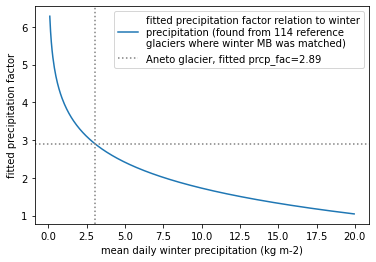

In [14]:
a_log_multiplied = -0.988689
b_intercept = 4.004772
def log_func(x, a, b):
    r = a*np.log(x) +b
    # don't allow extremely low/high prcp. factors!!!
    if np.shape(r) == ():
        if r > 10:
            r = 10
        if r<0.1:
            r=0.1
    else:
        r[r>10] = 10
        r[r<0.1] = 0.1
    return r

winter_prcp_values = np.arange(0.1, 20,0.05)
plt.plot(winter_prcp_values, log_func(winter_prcp_values, a_log_multiplied, b_intercept), label='fitted precipitation factor relation to winter\nprecipitation (found from 114 reference\nglaciers where winter MB was matched)')
fit_prcp_fac_aneto = log_func(ds_prcp_winter, a_log_multiplied, b_intercept)
plt.axvline(ds_prcp_winter, ls=':', color='grey', label=f'Aneto glacier, fitted prcp_fac={fit_prcp_fac_aneto:.2f}')
plt.axhline(fit_prcp_fac_aneto, ls=':', color='grey')
plt.ylabel('fitted precipitation factor')
plt.xlabel('mean daily winter precipitation (kg m-2)') # mean over 1979-2020
plt.legend()

In [15]:
# recalibrate melt_f with the new pf!
pf = fit_prcp_fac_aneto
melt_f_opt_0_5_m = scipy.optimize.brentq(minimize_bias_geodetic, 10, 1000,
                                     xtol=0.01, args=(mb_mod_monthly_0_5_m,
                                                      mb_geodetic,
                                                      h, w, pf, False,
                                                      years,
                                                      False, True, # do spinup before
                                                      ), disp=True)
# change the melt_f to the newly calibrated one
mb_mod_monthly_0_5_m.melt_f = melt_f_opt_0_5_m
spec_0_5_m = mb_mod_monthly_0_5_m.get_specific_mb(year=years, fls=fls)
# check if the calibration has worked as we expect:
np.testing.assert_allclose(spec_0_5_m.mean(), mb_geodetic, rtol = 1e-4)
print(melt_f_opt_0_5_m)

125.03340248339771


Text(0.5, 0, 'years')

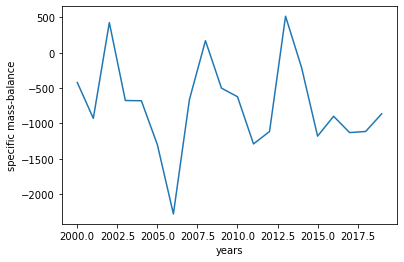

In [16]:
plt.plot(years, spec_0_5_m)
plt.ylabel('specific mass-balance')
plt.xlabel('years')

### Some more details about the applied surface type distinction method to get a melt factor that distinguishes between ice and snow age:

inside of `TIModel_Sfc_Type`, there is **a surface type distinction model included with a bucket system together with a melt_f that varies with age** :
- there are two options included at the moment:
    - `melt_f_update=annual`
        - If annual, then it uses 1 snow
            and 5 firn buckets with yearly melt factor updates.
    - `melt_f_update=monthly`:
        -  If monthly, each month the snow is ageing over 6 years (i.e., 72 months -> 72 buckets).
    - the ice bucket is thought as an "infinite" bucket (because we do not know the ice thickness at this model stage)
    - Melt factors are interpolated either:
        - linearly inbetween the buckets.
        - or using a negativ exponential change assumption with an e-folding change assumption of e.g. 0.5 or 1 year
- default is to use a **spinup** of 6 years. So to compute the specific mass balance between 2000 and 2020, with `spinup=True`, the annual mb is computed since 1994 where at first everything is ice, and then it accumulates over the next years, so that in 2000 there is something in each bucket ...
    - if we start in 1979 (start of W5E5), we neglect the spinup because we don't have climate data before 1979

- the ratio of snow melt factor to ice melt factor is set to 0.5 (as in GloGEM) but it can be changed via `melt_f_ratio_snow_to_ice`
    - if we set `melt_f_ratio_snow_to_ice=1` the melt factor is equal for all buckets, hence the results are equal to no surface type distinction (as in `TIModel`)
- `get_annual_mb` and `get_monthly_mb` work as in PastMassBalance, however they only accept the height array that corresponds to the inversion height (so no mass-balance elevation feedback can be included at the moment!)
    - that means the given mass-balance ist the mass-balance over the inversion heights (before doing the inversion and so on)
- the buckets are automatically updated when using `get_annual_mb` or `get_monthly_mb` via the `TIModel_Sfc_Type.pd_bucket` dataframe 
- to make sure that we do not compute mass-balance twice and to always have a spin-up of 6 years, the mass balance is automatically saved under 
    - `get_annual_mb.pd_mb_annual`: for each year
        - when using `get_monthly_mb` for several years, after computing the December month, the `pd_mb_annual` dataframe is updated
    - `get_annual_mb.pd_mb_monthly`: for each month 
        - note that this stays empty if we only use get_annual_mb with annual melt_f_update
        
        
**-> you will use melt_f_update=monthly, spinup=True, melt_f_ratio_snow_to_ice=0.5, a negativ exponential change assumption with an e-folding change assumption of 1 year (see more details in the following plots below)** 

Monthly MB is saved in TIModel_Sfc_Type instance:

In [17]:
# the first 6 years are the spinup
mb_mod_monthly_0_5_m.pd_mb_monthly


,1994.000000,1994.083333,1994.166667,1994.250000,1994.333333,1994.416667,1994.500000,1994.583333,1994.666667,1994.750000,...,2019.166667,2019.250000,2019.333333,2019.416667,2019.500000,2019.583333,2019.666667,2019.750000,2019.833333,2019.916667
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,1.107729e-07,1.357695e-07,3.976788e-08,1.843407e-07,8.381172e-08,-1.104271e-07,-2.952500e-07,-3.943526e-07,6.812420e-10,5.589295e-08,...,3.621250e-08,1.134461e-07,1.304884e-07,-1.131103e-07,-3.295801e-07,-3.588709e-07,-2.408198e-07,5.701541e-08,2.111098e-07,1.571480e-07
42.0,1.107729e-07,1.357695e-07,3.976788e-08,1.840558e-07,8.148855e-08,-1.136963e-07,-2.988105e-07,-4.029020e-07,-3.011461e-09,5.354993e-08,...,3.621250e-08,1.132325e-07,1.285551e-07,-1.154644e-07,-3.336046e-07,-3.671203e-07,-2.448841e-07,5.448766e-08,2.100802e-07,1.571480e-07
84.0,1.107729e-07,1.357695e-07,3.976788e-08,1.836676e-07,7.832340e-08,-1.182138e-07,-3.036678e-07,-4.145802e-07,-9.273392e-09,5.030718e-08,...,3.621250e-08,1.129413e-07,1.256715e-07,-1.186717e-07,-3.391397e-07,-3.784502e-07,-2.504215e-07,5.095044e-08,2.086774e-07,1.571480e-07
126.0,1.107729e-07,1.357695e-07,3.976788e-08,1.832704e-07,7.508448e-08,-1.229167e-07,-3.086461e-07,-4.265687e-07,-1.966417e-08,4.663633e-08,...,3.621250e-08,1.123991e-07,1.218749e-07,-1.221896e-07,-3.450421e-07,-3.906293e-07,-2.560880e-07,4.702995e-08,2.072419e-07,1.571480e-07
168.0,1.107729e-07,1.357695e-07,3.976788e-08,1.828865e-07,7.187207e-08,-1.279094e-07,-3.139474e-07,-4.380411e-07,-2.860988e-08,4.308790e-08,...,3.621250e-08,1.115938e-07,1.181922e-07,-1.258301e-07,-3.503701e-07,-4.025377e-07,-2.618856e-07,4.253916e-08,2.058543e-07,1.571480e-07
210.0,1.107729e-07,1.357695e-07,3.971486e-08,1.825583e-07,6.917225e-08,-1.321760e-07,-3.185548e-07,-4.477826e-07,-3.675408e-08,4.005498e-08,...,3.621250e-08,1.109056e-07,1.140629e-07,-1.290086e-07,-3.554029e-07,-4.130888e-07,-2.678554e-07,3.870350e-08,2.046683e-07,1.571480e-07
252.0,1.107729e-07,1.357695e-07,3.963178e-08,1.822205e-07,6.591407e-08,-1.365997e-07,-3.233714e-07,-4.580455e-07,-4.507043e-08,3.691818e-08,...,3.614496e-08,1.099738e-07,1.086224e-07,-1.323610e-07,-3.609755e-07,-4.244836e-07,-2.739995e-07,3.476088e-08,2.034476e-07,1.571480e-07
294.0,1.107729e-07,1.357695e-07,3.954615e-08,1.818724e-07,6.200608e-08,-1.411968e-07,-3.284189e-07,-4.688820e-07,-5.348468e-08,3.341965e-08,...,3.605933e-08,1.089783e-07,1.028404e-07,-1.357150e-07,-3.667408e-07,-4.360966e-07,-2.803324e-07,3.072521e-08,2.021894e-07,1.571480e-07
336.0,1.107729e-07,1.357695e-07,3.946379e-08,1.815375e-07,5.824737e-08,-1.456183e-07,-3.332735e-07,-4.793045e-07,-6.182895e-08,3.037850e-08,...,3.597697e-08,1.080209e-07,9.727928e-08,-1.388548e-07,-3.722702e-07,-4.466091e-07,-2.864233e-07,2.704065e-08,2.004304e-07,1.571480e-07


Also annual MB is saved in TIModel_Sfc_Type instance:

In [18]:
# the first 6 years are the spinup
mb_mod_monthly_0_5_m.pd_mb_annual


,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,4.346761e-09,1.307679e-09,4.601115e-08,-1.139029e-08,-5.587118e-09,-1.057257e-08,4.386637e-09,-1.089896e-08,3.062363e-08,-6.200111e-09,...,-1.074153e-09,-2.305912e-08,-1.766603e-08,3.400668e-08,9.058604e-09,-2.202344e-08,-1.396844e-08,-1.814321e-08,-1.950078e-08,-1.029782e-08
42.0,2.344839e-09,-1.037497e-09,4.441307e-08,-1.355695e-08,-7.389786e-09,-1.286807e-08,2.590421e-09,-1.297301e-08,2.878141e-08,-7.923734e-09,...,-3.041852e-09,-2.567170e-08,-1.986705e-08,3.224492e-08,7.256684e-09,-2.433613e-08,-1.582222e-08,-2.046119e-08,-2.183315e-08,-1.233088e-08
84.0,-4.977319e-10,-4.847455e-09,4.220639e-08,-1.654426e-08,-1.020002e-08,-1.597005e-08,1.435566e-10,-1.624987e-08,2.617278e-08,-1.067712e-08,...,-6.072092e-09,-2.925333e-08,-2.298665e-08,2.981817e-08,4.813024e-09,-2.743323e-08,-1.844413e-08,-2.377759e-08,-2.500503e-08,-1.514125e-08
126.0,-3.778359e-09,-8.940597e-09,3.983048e-08,-1.965449e-08,-1.339235e-08,-1.893899e-08,-2.450862e-09,-2.023334e-08,2.356205e-08,-1.370277e-08,...,-9.497605e-09,-3.285070e-08,-2.637697e-08,2.730825e-08,2.451406e-09,-3.059180e-08,-2.131619e-08,-2.723219e-08,-2.819931e-08,-1.822131e-08
168.0,-6.933108e-09,-1.262673e-08,3.748792e-08,-2.271777e-08,-1.664052e-08,-2.191505e-08,-5.715534e-09,-2.389824e-08,2.118806e-08,-1.653809e-08,...,-1.284952e-08,-3.630776e-08,-2.983607e-08,2.479128e-08,2.001523e-10,-3.388791e-08,-2.408158e-08,-3.066693e-08,-3.128906e-08,-2.130804e-08
210.0,-9.672567e-09,-1.587871e-08,3.552648e-08,-2.529344e-08,-1.954007e-08,-2.451120e-08,-8.624174e-09,-2.702186e-08,1.915715e-08,-1.896320e-08,...,-1.576864e-08,-3.927733e-08,-3.300778e-08,2.264725e-08,-1.813797e-09,-3.673271e-08,-2.649498e-08,-3.361945e-08,-3.390144e-08,-2.418901e-08
252.0,-1.255885e-08,-1.914763e-08,3.349629e-08,-2.817860e-08,-2.255259e-08,-2.736428e-08,-1.167525e-08,-3.016068e-08,1.705603e-08,-2.152753e-08,...,-1.890620e-08,-4.230529e-08,-3.625202e-08,2.041967e-08,-4.193524e-09,-3.959900e-08,-2.910202e-08,-3.668048e-08,-3.657466e-08,-2.736124e-08
294.0,-1.562016e-08,-2.259333e-08,3.138306e-08,-3.127059e-08,-2.560773e-08,-3.026325e-08,-1.504630e-08,-3.341307e-08,1.487059e-08,-2.406296e-08,...,-2.220426e-08,-4.547757e-08,-3.963159e-08,1.808243e-08,-6.857731e-09,-4.236576e-08,-3.185229e-08,-3.989783e-08,-3.942107e-08,-3.062975e-08
336.0,-1.856167e-08,-2.591551e-08,2.933487e-08,-3.421251e-08,-2.847427e-08,-3.306229e-08,-1.831239e-08,-3.648340e-08,1.274290e-08,-2.655903e-08,...,-2.537788e-08,-4.862721e-08,-4.289855e-08,1.579887e-08,-9.446747e-09,-4.496223e-08,-3.445346e-08,-4.310379e-08,-4.233705e-08,-3.373952e-08


Buckets when using monthly melt_f_update:

In [19]:
# this is the output after updating the surface type (and before the next month)
# hence: the "youngest" bucket 0 is 0 (because already updated to next older month!)
mb_mod_monthly_0_5_m.pd_bucket 

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,delta_kg/m2
distance_along_flowline,,,,,,,,,,,,,,,,,,,,,
0.0,0.0,371.686367,499.316982,134.852853,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
42.0,0.0,371.686367,496.881711,128.874217,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
84.0,0.0,371.686367,493.563841,120.507984,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
126.0,0.0,371.686367,490.168640,111.235249,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
168.0,0.0,371.686367,486.886603,100.613614,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
210.0,0.0,371.686367,484.081401,91.541522,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
252.0,0.0,371.686367,481.194307,82.216443,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
294.0,0.0,371.686367,478.218465,72.671275,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
336.0,0.0,371.686367,474.058087,63.956552,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


**Example plot with monthly melt_f update:**

In [20]:
mb = mb_mod_monthly_0_5_m
name = '0_5_m_neg_exp_tau1yr'
mb.get_specific_mb(year=years, fls=fls)
mb_annual_dict_name = {}
for y in years:
    mb_y = mb.pd_mb_annual[y]  # output is in m of ice per second ! (would be the same as doing `mb.get_annual_mb(h, y)`)
    mb_y = mb_y * mb.SEC_IN_YEAR * mb.rho
    mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_y<0], y=mb_y[mb_y<0]) 
    mb_annual_dict_name[y] = mb_y

Text(0, 0.5, 'altitude (m)')

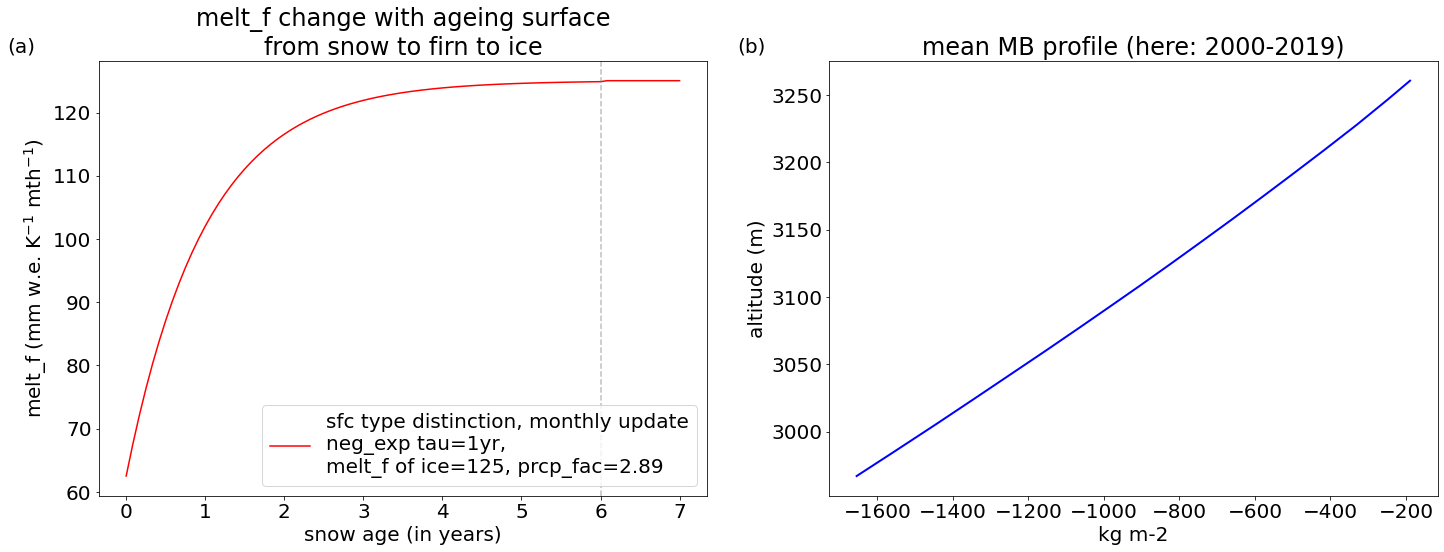

In [21]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(24, 8))
lw=2
plt.subplot(121)
plt.title('melt_f change with ageing surface\nfrom snow to firn to ice')
ax = plt.gca()
plt.text(-0.15,1.02,'(a)', transform=ax.transAxes)

meltis = []
for _,m in mb_mod_monthly_0_5_m.melt_f_buckets.items():
    meltis.append(m)
for m in np.arange(0,12):
    meltis.append(mb_mod_monthly_0_5_m.melt_f)
    
plt.plot(np.arange(0,7.01,1/12), meltis, color='red', label='sfc type distinction, monthly update\nneg_exp tau=1yr,\nmelt_f of ice={:1.0f}, prcp_fac={:.2f}'.format(melt_f_opt_0_5_m, fit_prcp_fac_aneto))
# plt.plot(np.arange(0,7.01,1/12), meltis, color='red', label='sfc type distinction, monthly update\nexp. change (tau=1yr), melt_f={:0.1f}'.format(melt_f_opt_0_5_m_neg_exp_tau1yr))
plt.xticks(np.arange(0,7.1,1))


plt.xlabel('snow age (in years)')
#plt.yticks(np.arange(0,1250,300,350,400,450,500,550])
plt.ylabel(r'melt_f (mm w.e. K$^{-1}$ mth$^{-1}$)')

handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels)
plt.axvline(6, color='grey', ls='--', alpha=0.5)

plt.subplot(122)
ax = plt.gca()
plt.text(-0.15,1.02,'(b)', transform=ax.transAxes)
plt.plot(pd.DataFrame(mb_annual_dict_name).mean(axis=1).values,
         h, color = 'blue', 
         lw=lw)

plt.title('mean MB profile (here: 2000-2019)')
plt.xlabel('kg m-2')
plt.ylabel('altitude (m)')

In [22]:
# can also just look at seasonal MB profiles
mb.reset_pd_mb_bucket()
mb_grad_dict_name = []
mb_monthly_dict_name = {}
bucket_name = {}
for y in years:
    for m in np.arange(1,13,1):
        floatyr = date_to_floatyear(y,m)
        #if name != '0_5_m':
        _, bucket_name[floatyr] = mb.get_monthly_mb(h, year=floatyr, bucket_output =True)
        mb_m = mb.pd_mb_monthly[floatyr]  # output is in m of ice per second !
        try:
            mb_gradient,_,_,_,_ = scipy.stats.linregress(h[mb_m<0], y=mb_m[mb_m<0]) 
        except:
            mb_gradient = np.NaN
        mb_monthly_dict_name[floatyr] = mb_m

/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:175: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:189: RuntimeWarning: invalid value encountered in sqrt
  t = r * np.sqrt(df / ((1.0 - r + TINY)*(1.0 + r + TINY)))
/home/lilianschuster/anaconda3/envs/pymc3_oggm/lib/python3.9/site-packages/scipy/stats/_stats_mstats_common.py:192: RuntimeWarning: invalid value encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)


Text(0.5, 0, 'kg m-2')

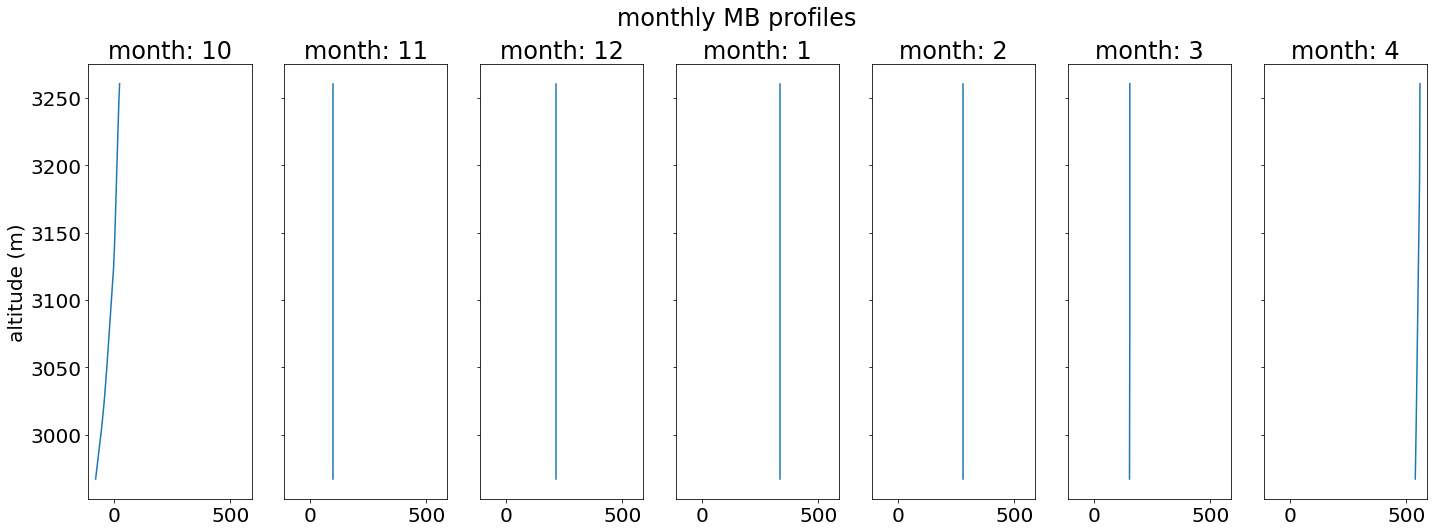

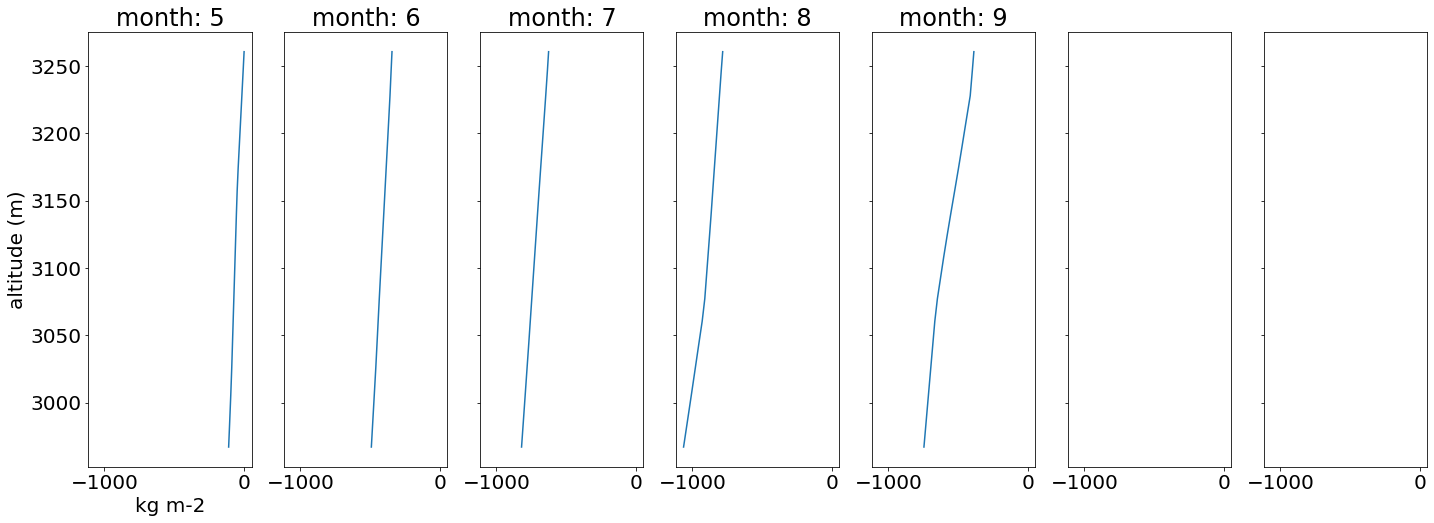

In [23]:
## also get winter / summer MB profiles
y0 = 1980 
m_winter_mb = [10,11,12,1,2,3,4]
m_summer_mb = [5,6,7,8,9]
yr_changes = True
m_start = 10
add_climate = True
ratio = 1
melt_m_10 = {}
melt_m_4 = {}
melt_m_5 = {}
mb_grad_winter = {}
mb_grad_summer = {}
mb_grad_winter_melt = {}
mb_grad_summer_melt = {}
color_dict = {'1_a': 'black', '0_5_m':'blue', '0_5_m_neg_exp':'red'}
fig_w, axs_w = plt.subplots(1,7, figsize=(24,8), sharey=True, sharex=True)
plt.suptitle('monthly MB profiles')

fig_s, axs_s = plt.subplots(1,7, figsize=(24,8), sharey=True, sharex=True)

mb.reset_pd_mb_bucket()
_ = mb.get_specific_mb(h, widths=w, year=np.arange(1979,2020,1))

pd_winter_mb = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
pd_summer_mb = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
pd_winter_melt = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
pd_summer_melt = pd.DataFrame(index=h, columns=np.arange(y0,2020,1))
# Let's plot monthly MB profiles of that year!!
for year in np.arange(y0, 2020,1):
    mbs_winter = 0
    mbs_summer = 0
    prcp_sol_winter = 0
    prcp_sol_summer = 0

    for j,m in enumerate(m_winter_mb):
        if (m in np.arange(m_start, 13, 1)) and (yr_changes):
            floatyr = utils.date_to_floatyear(year-1, m)
        else:
            floatyr = utils.date_to_floatyear(year, m)
        out = mb.get_monthly_mb(h, year=floatyr, add_climate=True)
        out, t, tfm, prcp, prcp_sol = out
        mbs_winter += out * ratio
        prcp_sol_winter += prcp_sol *ratio
        if (year== 2008 and m>=10) or (year == 2009 and m<10):
            try:
                if m == 10 and year == 2008:
                    melt_m_10[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
                elif m == 4 and year == 2009:
                    melt_m_4[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
                axs_w[j].plot(out*mb.SEC_IN_MONTH *mb.rho, h)
                axs_w[j].set_title(f'month: {m}')
            except:
                pass
        #mbs_winter += mb_winter_m
    for jj, m in enumerate(m_summer_mb):
        floatyr = utils.date_to_floatyear(year, m)
        out = mb.get_monthly_mb(h, year=floatyr, add_climate=True)
        out, t, tfm, prcp, prcp_sol = out
        mbs_summer += out * ratio
        prcp_sol_summer += prcp_sol *ratio
        if (year== 2008 and m>=10) or (year == 2009 and m<10):
            try:
                if m == 5 and year == 2009:
                    melt_m_5[name] = out*mb.SEC_IN_MONTH * mb.rho-prcp_sol
            except:
                pass
        if year == 2009:
            try:
                axs_s[jj].plot(out*mb.SEC_IN_MONTH * mb.rho, h)
                axs_s[jj].set_title(f'month: {m}')
            except:
                pass


    mbs_winter = mbs_winter * mb.SEC_IN_MONTH * mb.rho
    mbs_summer = mbs_summer * mb.SEC_IN_MONTH * mb.rho

    pd_winter_mb.loc[h, year] = mbs_winter
    pd_summer_mb.loc[h, year] = mbs_summer

    pd_winter_melt.loc[h, year] = mbs_winter-prcp_sol_winter
    pd_summer_melt.loc[h, year] = mbs_summer-prcp_sol_summer



mb_grad_winter[name] = pd_winter_mb.mean(axis=1).values, pd_winter_mb.mean(axis=1).index
mb_grad_summer[name] = pd_summer_mb.mean(axis=1).values, pd_summer_mb.mean(axis=1).index

mb_grad_winter_melt[name] = pd_winter_melt.mean(axis=1).values, pd_winter_melt.mean(axis=1).index
mb_grad_summer_melt[name] = pd_summer_melt.mean(axis=1).values, pd_summer_melt.mean(axis=1).index

axs_s[0].set_ylabel('altitude (m)')
axs_w[0].set_ylabel('altitude (m)')
axs_s[0].set_xlabel('kg m-2')


You can get the monthly climate like that:

In [24]:
m=1
temp, tfm, prcp, prcp_solid = mb.get_monthly_climate(h, year=utils.date_to_floatyear(2009, m))
temp, tfm, prcp, prcp_solid

(array([-10.68731123, -10.60937125, -10.50318343, -10.39451891,
        -10.28947836, -10.19969851, -10.10729701, -10.01205546,
         -9.92045313,  -9.83040911,  -9.74325282,  -9.65662676,
         -9.56235415,  -9.46701628,  -9.36836297,  -9.25411946,
         -9.13094288,  -9.03771883]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.]),
 array([334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994]),
 array([334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994, 334.90036994, 334.90036994,
        334.90036994, 334.90036994]))

**One year of snow ageing on the glacier (here for 2008-10 to 2009-09)**:

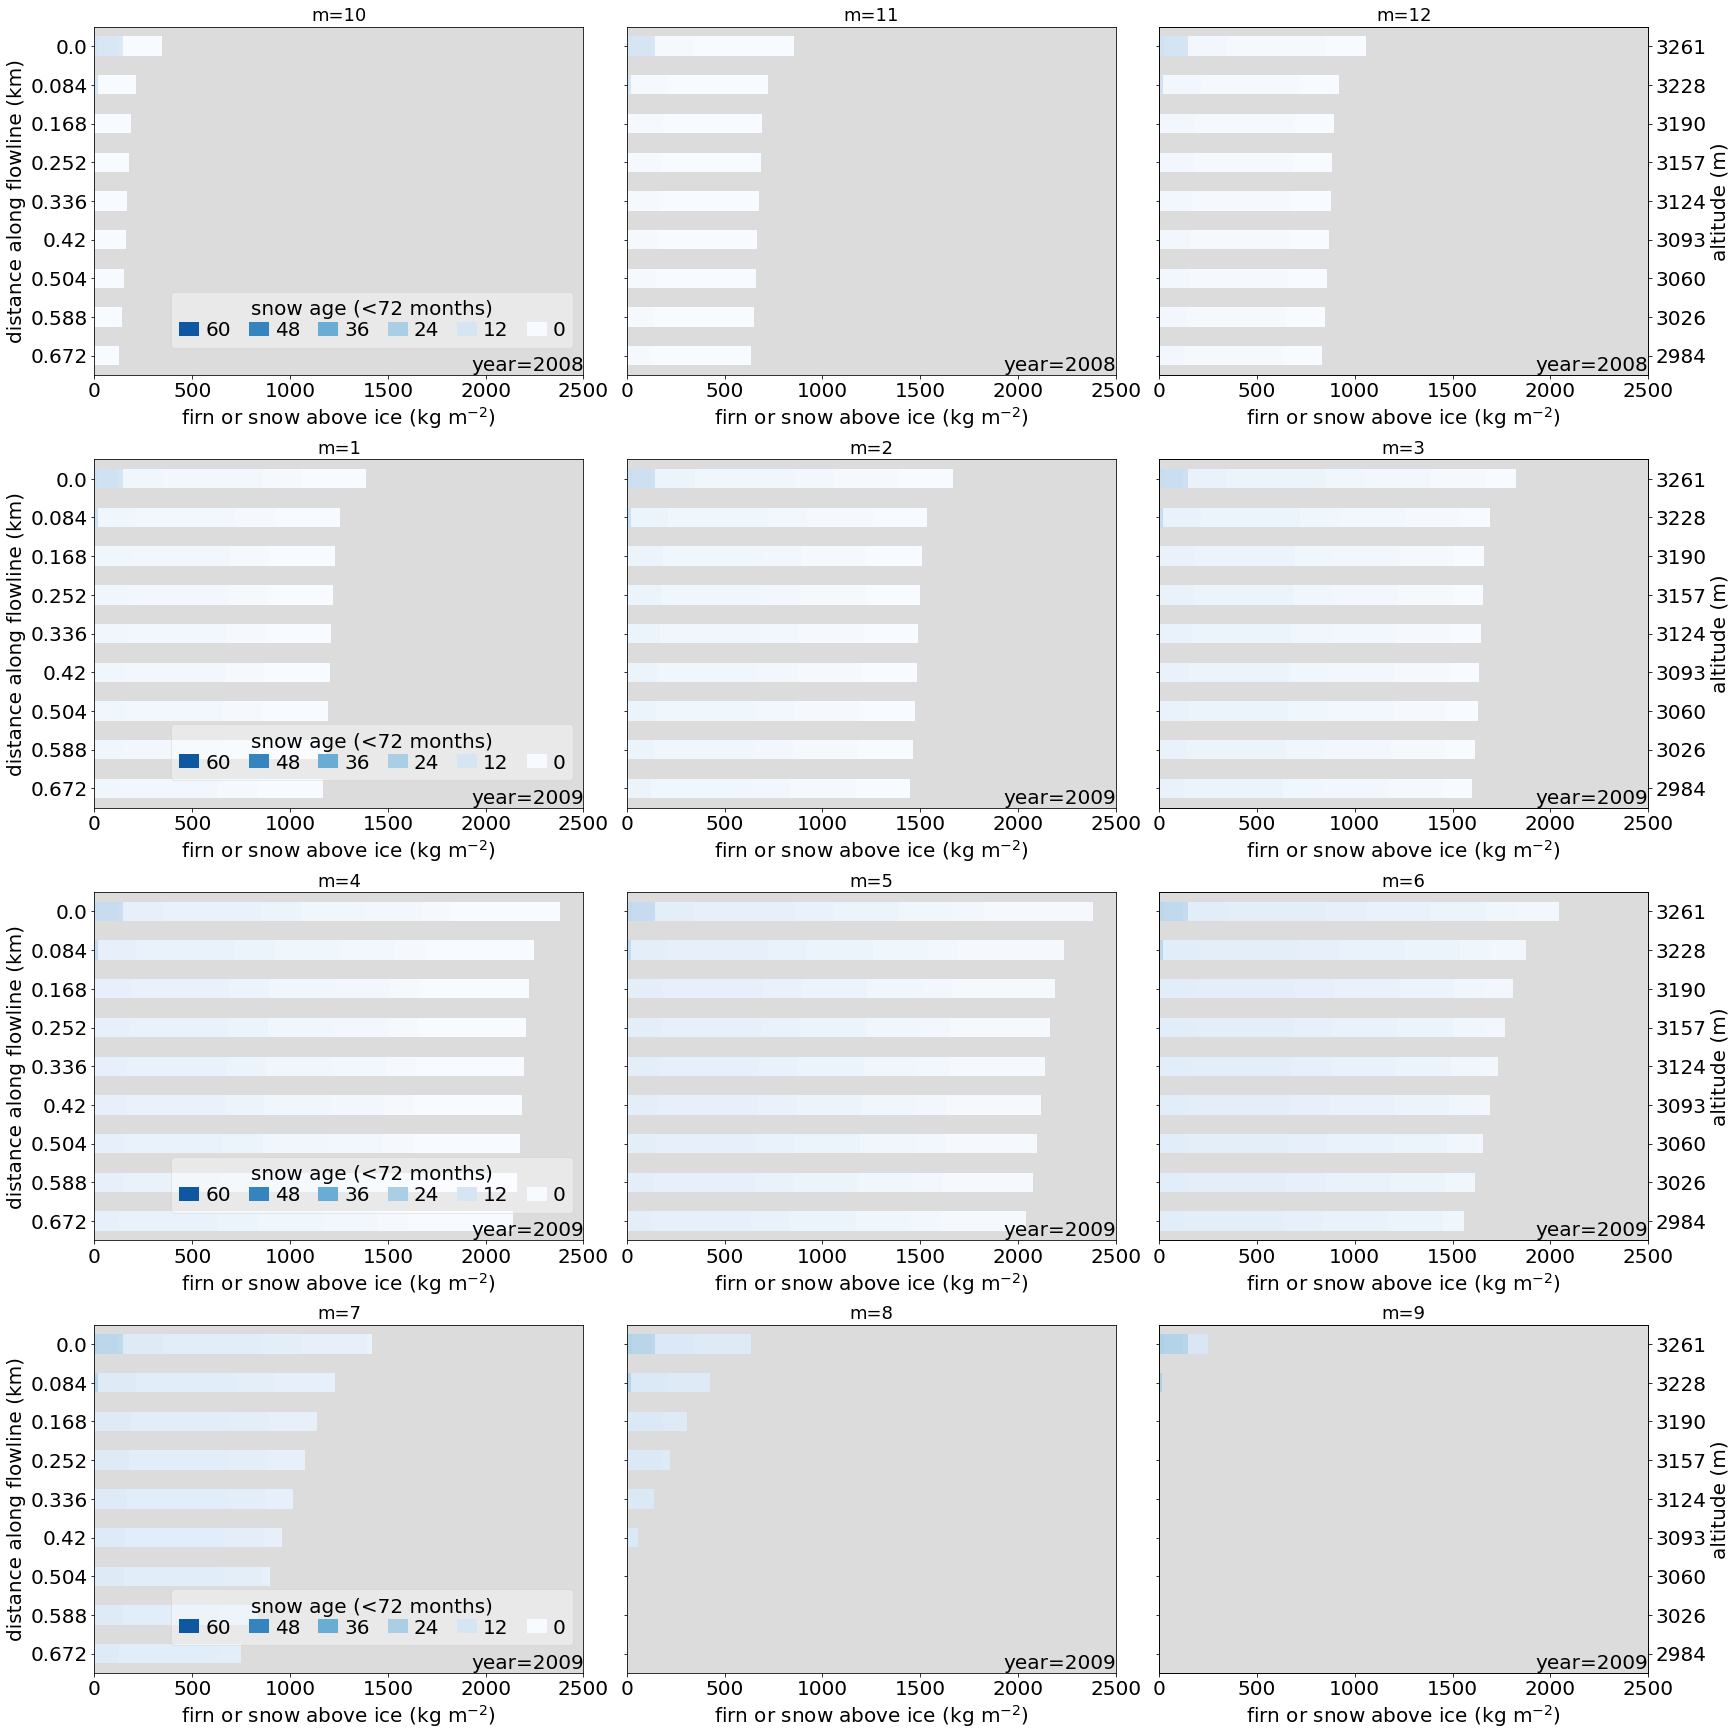

In [25]:
name = '0_5_a'
fig, axs = plt.subplots(4, 3, #gridspec_kw={'width_ratios': [1,1,1]},
                        figsize=(24, 24),
                       constrained_layout=True, sharey=True)

for j,m in enumerate([10,11,12,1,2,3,4,5,6,7,8,9]):
    if m in [10,11,12]:
        k = 0
    elif m in [1,2,3]:
        k=1
        j = j-3
    elif m in [4,5,6]:
        k=2
        j = j-6
    else:
        k=3
        j=j-9
    ax = axs[k,j]
    ax.set_facecolor('gainsboro')
    if m >= 10:
        year = 2008#9 # 2001
    else:
        year = 2009 #10 # 2000

    floatyr = utils.date_to_floatyear(year, m)
    
    sns_pd_bucket_sel = bucket_name[floatyr].copy()
    sns_pd_bucket_sel['altitude (m)'] = h.round(1)
    sns_pd_bucket_sel = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[::-1]]
    
    sns_pd_bucket_sel.index = bucket_name[floatyr].index #sns_pd_bucket_sel['altitude (m)']
    # only plot every second altitude band !!! 
    sns_pd_bucket_sel = sns_pd_bucket_sel.iloc[::2]
    pd_pivot = sns_pd_bucket_sel[sns_pd_bucket_sel.columns[2:]]
    pd_pivot.index = pd_pivot.index/1000
    pd_pivot = pd_pivot.sort_index(ascending=False)

    pd_pivot.plot.barh(stacked=True, ax= ax,
                       colormap='Blues_r', 
                       )

    han, lab = ax.get_legend_handles_labels()
    ax.get_legend().remove()
    if j == 0:
        ax.legend(handles = [han[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  labels = [lab[k-1] for k in [12, 24, 36, 48, 60, 72]],
                  title='snow age (<72 months)',  loc = 4, framealpha = 0.4, ncol=6,
                  bbox_to_anchor=(1,0.05),
                  labelspacing=0.1, handlelength=1, handletextpad=0.3, columnspacing=0.9);
        ax.set_ylabel('distance along flowline (km)')
    
    ax.set_xlabel(r'firn or snow above ice (kg m$^{-2}$)')
    ax.set_title(f'm={m}', fontsize=18)
    if m>= 10:
        ax.text(0.77,0.012, 'year=2008', transform=ax.transAxes)
    else:
        ax.text(0.77,0.012, 'year=2009', transform=ax.transAxes)
    if j == 2:
        ax2 = ax.twinx()
        pd_pivot.plot.barh(stacked=True, ax= ax2,
                   colormap='Blues_r', alpha = 0,
                   )
        ax2.set_yticklabels(h[::2].round(0).astype(int)[::-1])
        ax2.set_ylabel('altitude (m)')
        ax2.get_legend().remove()
    ax.set_xlim([0,2500])

### Inversion with Glen-A calibration

(to match ice thickness estimate of Farinotti(2020))

In [26]:
#Computes the Flowline along the unglaciated downstream topography
tasks.compute_downstream_line(gdir)
# The bedshape obtained by fitting a parabola to the line’s normals. Also computes the downstream’s altitude.
tasks.compute_downstream_bedshape(gdir)

# get the apparent_mb (necessary for inversion)
ye = 2020
climate.apparent_mb_from_any_mb(gdir, mb_model=mb,
                                mb_years=np.arange(2000, ye, 1))



2022-04-29 20:16:30: oggm.core.centerlines: (RGI60-11.03208) compute_downstream_line
2022-04-29 20:16:30: oggm.core.centerlines: (RGI60-11.03208) compute_downstream_bedshape
2022-04-29 20:16:31: oggm.core.climate: (RGI60-11.03208) apparent_mb_from_any_mb


In [27]:
# here glen-a is calibrated to match gdirs glaciers in total (as there is only one glacier, it just matches perfectly the one glacier!)
border = 80
filter = border >= 20
pd_inv_melt_f = oggm.workflow.calibrate_inversion_from_consensus(gdirs,
                                                      apply_fs_on_mismatch=False,ignore_missing=False,
                                                      error_on_mismatch=True,
                                                      filter_inversion_output=filter)
# so for init_present_time_glacier, automatically the new glen a volume inversion is used!
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs)

2022-04-29 20:16:31: oggm.workflow: Applying global task calibrate_inversion_from_consensus on 1 glaciers
2022-04-29 20:16:31: oggm.workflow: Consensus estimate optimisation with A factor: 0.1 and fs: 0
2022-04-29 20:16:31: oggm.workflow: Applying global task inversion_tasks on 1 glaciers
2022-04-29 20:16:31: oggm.workflow: Execute entity tasks [prepare_for_inversion] on 1 glaciers
2022-04-29 20:16:31: oggm.core.inversion: (RGI60-11.03208) prepare_for_inversion
2022-04-29 20:16:31: oggm.workflow: Execute entity tasks [mass_conservation_inversion] on 1 glaciers
2022-04-29 20:16:31: oggm.core.inversion: (RGI60-11.03208) mass_conservation_inversion
2022-04-29 20:16:31: oggm.workflow: Execute entity tasks [filter_inversion_output] on 1 glaciers
2022-04-29 20:16:31: oggm.core.inversion: (RGI60-11.03208) filter_inversion_output
2022-04-29 20:16:31: oggm.workflow: Execute entity tasks [get_inversion_volume] on 1 glaciers
2022-04-29 20:16:31: oggm.core.inversion: (RGI60-11.03208) get_inversion

[None]

In [28]:
# double check: volume of Farinotti estimate is equal to calibrated oggm estimate
# so estimates by Farinotti exist for each glacier individually?
np.testing.assert_allclose(pd_inv_melt_f.sum()['vol_itmix_m3'], pd_inv_melt_f.sum()['vol_oggm_m3'], rtol = 1e-2)
pd_inv_melt_f

,vol_itmix_m3,vol_bsl_itmix_m3,vol_oggm_m3
RGIId,,,
RGI60-11.03208,1.564802e+07,0.0,1.564183e+07


###  just looking at volume changes starting from rgi_date until end of calibration time period or until the end of the century:

In [29]:
gdir.rgi_date

2011

2022-04-29 20:17:55: oggm.workflow: Execute entity tasks [run_from_climate_data_TIModel] on 1 glaciers
2022-04-29 20:17:55: MBsandbox.flowline_TIModel: (RGI60-11.03208) run_from_climate_data_TIModel_historical_run
2022-04-29 20:17:55: oggm.core.flowline: (RGI60-11.03208) flowline_model_run_historical_run
2022-04-29 20:17:56: oggm.utils: Applying global task compile_run_output on 1 glaciers
2022-04-29 20:17:56: oggm.utils: Applying compile_run_output on 1 gdirs.


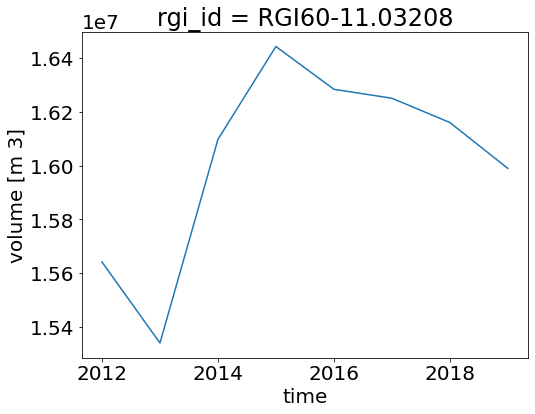

In [37]:
y0=2004 # but actually rgi date of Aneto glacier is in 2011 -> so it is just a very short time period ... 
ye_h = ye-1   
from MBsandbox.flowline_TIModel import run_from_climate_data_TIModel
workflow.execute_entity_task(run_from_climate_data_TIModel, gdirs, bias=0, #will actually point to the residual, should always be zero! 
                                  mb_model_sub_class=TIModel_Sfc_Type, # we use the temperature-index model variant with surface type distinction!
                                  min_ys=y0, ye=ye_h, # starting and end year of the volume run 
                                  mb_type=mb_type,
                                  grad_type=grad_type,
                                  precipitation_factor=fit_prcp_fac_aneto,  # take the fitted precipitation factor
                                  melt_f=melt_f_opt_0_5_m, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                                  climate_input_filesuffix=baseline_climate, # we use here the observational W5E5 climate dataset
                                  output_filesuffix='_historical_run',# can add here more options to distinguish between runs
                             store_model_geometry =True
                                 )
ds_vol = utils.compile_run_output(gdirs, input_filesuffix='_historical_run')
plt.figure(figsize=(8,6))
ds_vol.sel(rgi_id=df[-1]).volume.plot()

ok, we just have a very first look at how the volume evolves under the lowest emission scenario for just one gcm ensemble (with the chosen MB model):

In [31]:
ensemble = 'mri-esm2-0_r1i1p1f1'
ssp = 'ssp126'
from MBsandbox.wip.projections_bayescalibration import process_isimip_data
workflow.execute_entity_task(process_isimip_data, gdirs, ensemble = ensemble,
                                 ssp = 'ssp126', temporal_resol ='daily',
                                  climate_historical_filesuffix='_{}_{}'.format('daily', baseline_climate), correct=False)
workflow.execute_entity_task(run_from_climate_data_TIModel, gdirs, bias=0, #will actually point to the residual, should always be zero! 
                                  mb_model_sub_class=TIModel_Sfc_Type, # we use the temperature-index model variant with surface type distinction!
                            #min_ys=y0,
                             ye=2100, # starting and end year of the volume run 
                                  mb_type=mb_type,
                                  grad_type=grad_type,
                                  precipitation_factor=fit_prcp_fac_aneto,  # take the fitted precipitation factor
                                  melt_f=melt_f_opt_0_5_m, # set to the calibrated melt_f (that fits to fit_prcp_fac_aneto)
                             init_model_filesuffix = '_historical_run',  # start from the stage of the end of the historical run 
                             #climate_type = 'gcm_data',
                             climate_filename='gcm_data',
                                  climate_input_filesuffix=f'ISIMIP3b_{ensemble}_{ssp}_no_correction', 
                                  output_filesuffix=f'_gcm_run_{ensemble}_{ssp}', # can add here more options to distinguish between runs
                             store_model_geometry = True
                                 )
ds_vol_future = utils.compile_run_output(gdirs, input_filesuffix=f'_gcm_run_{ensemble}_{ssp}')

2022-04-29 20:16:34: oggm.workflow: Execute entity tasks [process_isimip_data] on 1 glaciers
2022-04-29 20:16:34: MBsandbox.wip.projections_bayescalibration: (RGI60-11.03208) process_isimip_data
2022-04-29 20:16:34: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/isimip3b_flat/flat/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp126_tasAdjust_global_daily_flat_glaciers.nc
2022-04-29 20:16:34: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/isimip3b_flat/flat/daily/mri-esm2-0_r1i1p1f1_w5e5_historical_tasAdjust_global_daily_flat_glaciers.nc
2022-04-29 20:16:34: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/isimip3b_flat/flat/daily/mri-esm2-0_r1i1p1f1_w5e5_ssp126_prAdjust_global_daily_flat_glaciers.nc
2022-04-29 20:16:34: oggm.utils: No known hash for cluster.klima.uni-bremen.de/~lschuster/isimip3b_flat/flat/daily/mri-esm2-0_r1i1p1f1_w5e5_historical_prAdjust_global_daily_flat_glaciers.nc
2022-04-29 20:16:56: MBsandbox.wip.projections_baye

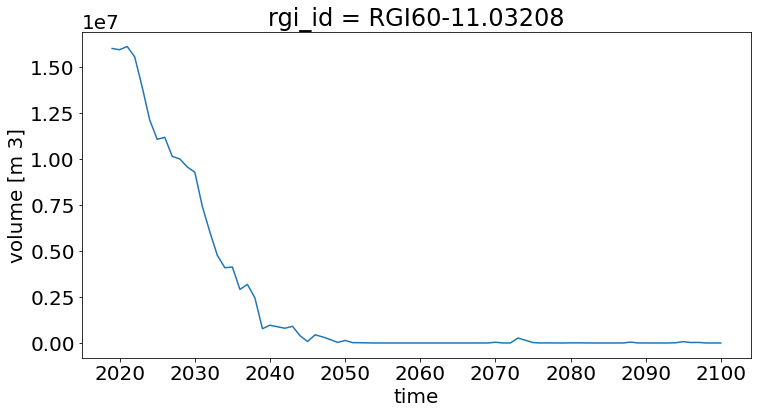

In [38]:
plt.figure(figsize=(12,6))
ds_vol_future.sel(rgi_id=df[-1]).volume.plot()